# Fall 2024 CBE 162 Lab 9: Tuning and Stability Analysis

## Objective
In this lab, we will explore the tuning and stability of a closed-loop control system using **Direct Synthesis** tuning. Additionally, we will verify system stability using the **Routh Stability Criterion** and evaluate the system's performance through the **Integrated Square Error (ISE)** metric.

## System Description
We will work with a first-order system with the following characteristics:
- Gain ($K_s$)
- Time constant ($\tau_s$)
- Dead time ($\theta$)

Components of the system include:
- **Actuator**: Zeroth-order with gain $K_a = 1$
- **Measurement device**: Zeroth-order with gain $K_m = 1$
- **PID controller**: with transfer function:
$$ G_c(s) = K_p \left(1 + \frac{1}{\tau_I s} + \tau_D s \right) $$

### Parameters
Ensure the following initial values are used:
- $K_s = 11.6$, $\tau_s = 6$, $\theta = 0.2$
- $K_a = 1.0$, $K_m = 1.0$
- PID parameters: $K_p = 1$, $\tau_I = 1$, $\tau_D = 1$

## Problem 1: Building the Closed-Loop Transfer Function
**Step 1**: Construct the transfer function for the closed-loop system.

**Tasks**:
1. Define the transfer function of the first-order system.
2. Create the PID controller transfer function in terms of $K_p$, $\tau_I$, and $\tau_D$.
3. Combine these using `signal.TransferFunction` to obtain the closed-loop transfer function.

Implement the closed-loop transfer function that maps the controller setpoint to the output response.



In [12]:
# Define the transfer function components
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.signal import tf2zpk, TransferFunction, step

Ks = 11.6
taus = 6
theta = 0.20

Ka = 1.0
Km = 1.0

Kp = 1
tauI = 1
tauD = 1

# Your transfer function code here

# 1.)
numerator_plant = [Ks]
denominator_plant = [taus, 1]

first_order_tf = TransferFunction(numerator_plant, denominator_plant)

numerator_deadtime = [1, -theta / 2]
denominator_deadtime = [1, theta / 2]

# 2.)
numerator_pid = [Kp * tauD * tauI, Kp * tauI, Kp]
denominator_pid = [tauI, 0]
numerator_open_loop = np.polymul(numerator_plant, numerator_pid)
denominator_open_loop = np.polymul(denominator_plant, denominator_pid)

numerator_open_loop = np.polymul(numerator_open_loop, numerator_deadtime)
denominator_open_loop = np.polymul(denominator_open_loop, denominator_deadtime)

# 3.)
numerator_closed_loop = numerator_open_loop
denominator_closed_loop = np.polyadd(denominator_open_loop, numerator_open_loop)

closed_loop_tf = TransferFunction(numerator_closed_loop, denominator_closed_loop)



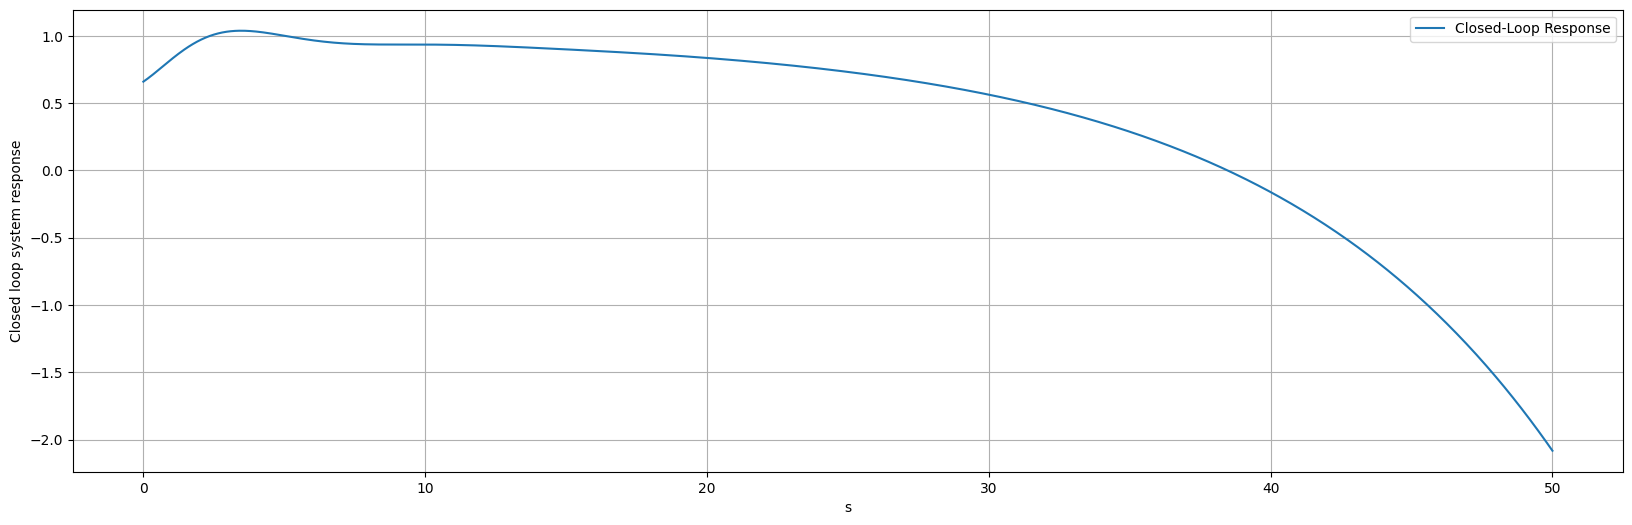

In [13]:
time = np.linspace(0, 50, 1000)
time, response = step(closed_loop_tf, T=time)

plt.figure(figsize=(20, 6))
plt.plot(time, response, label="Closed-Loop Response")
plt.xlabel("s")
plt.ylabel("Closed loop system response")
plt.grid()
plt.legend()
plt.show()

## Problem 2: Applying Direct Synthesis Tuning
**Objective**: Use the **Direct Synthesis tuning** method to set PID parameters.

**Tasks**:
1. Calculate the desired closed-loop transfer function based on a specified target time constant.
2. Adjust $K_p$, $\tau_I$, and $\tau_D$ to match the Direct Synthesis method.
3. Plot the system response from $t=0$ to $t=36$ seconds.

**Questions**:
- How does Direct Synthesis tuning compare to the previous controller in terms of stability?
- Document any instability observed, and note changes that stabilize the response.
Write your answer as a comment at the end of your code.

In [14]:
# Direct Synthesis Tuning implementation
desired_time_constant = tau_c = 5
numerator_cl = [1]
denominator_cl = [tau_c, 1]
numerator_controller = np.polymul(numerator_cl, denominator_deadtime)
denominator_controller = np.polymul(denominator_cl, [Ks, 0])  

Kp = numerator_controller[0]
tauI = denominator_controller[1] / numerator_controller[0]
tauD = numerator_deadtime[0] / numerator_controller[0]

print(f"Direct Synthesis PID Parameters:")
print(f"Kp: {Kp}")
print(f"tauI: {tauI}")
print(f"tauD: {tauD}")

# Your Direct Synthesis tuning code here
numerator_pid = [Kp * tauD, Kp, Kp / tauI]
denominator_pid = [1, 0]
numerator_plant = [Ks]
denominator_plant = [taus, 1]
numerator_open_loop = np.polymul(np.polymul(numerator_plant, numerator_deadtime), numerator_pid)
denominator_open_loop = np.polymul(np.polymul(denominator_plant, denominator_deadtime), denominator_pid)

numerator_closed_loop = numerator_open_loop
denominator_closed_loop = np.polyadd(denominator_open_loop, numerator_open_loop)

closed_loop_tf = TransferFunction(numerator_closed_loop, denominator_closed_loop)
time = np.linspace(0, 36, 1000)
time, response = step(closed_loop_tf, T=time)

# - How does Direct Synthesis tuning compare to the previous controller in terms of stability?
# The tuning seems more stable initially as the oscillation has attenuated

# - Document any instability observed, and note changes that stabilize the response.
# The instability seen initially in the first controller has attenuated so now there is low instability. There is a small oscillation in the response initially still. 

Direct Synthesis PID Parameters:
Kp: 1.0
tauI: 11.6
tauD: 1.0


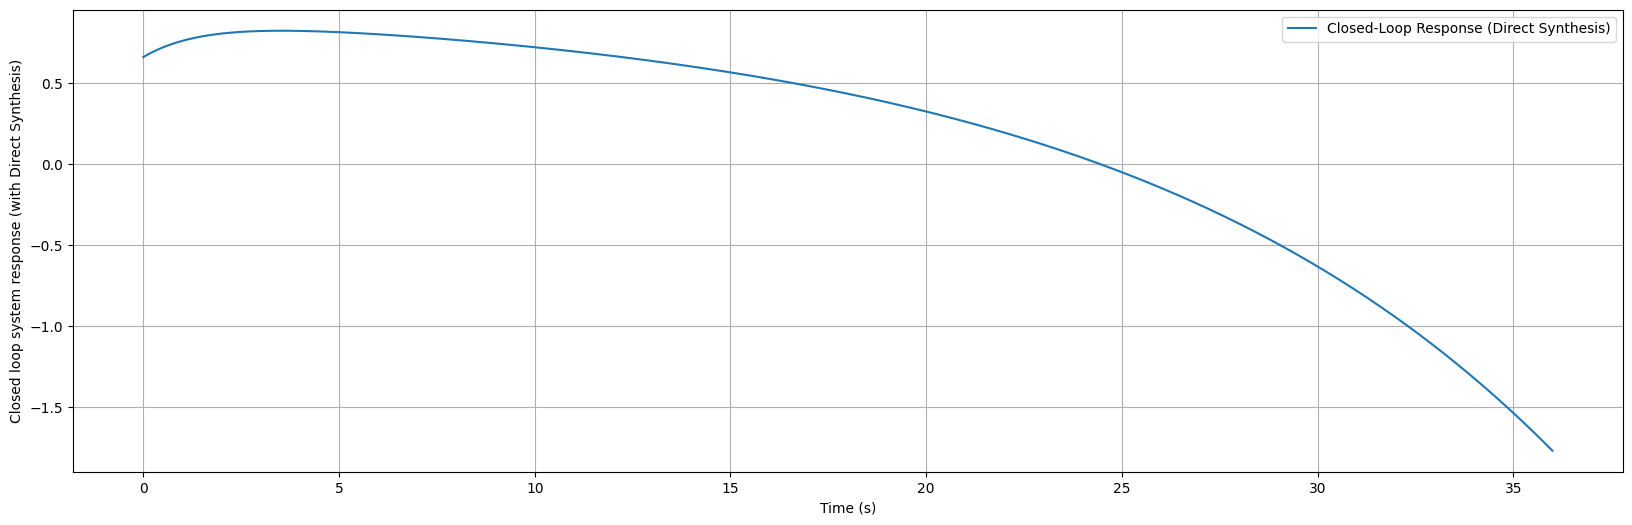

In [15]:
plt.figure(figsize=(20, 6))
plt.plot(time, response, label="Closed-Loop Response (Direct Synthesis)")
plt.xlabel("Time (s)")
plt.ylabel("Closed loop system response (with Direct Synthesis)")
plt.grid()
plt.legend()
plt.show()


## Problem 3: Stability Verification using the Routh Stability Criterion
**Objective**: Verify system stability by applying the **Routh Stability Criterion** to the characteristic equation.

**Tasks**:

1. Apply the Routh Stability Criterion to determine stability.Use numpy arrays for this task.




In [16]:
# Routh Stability Criterion

def construct_routh_array(coefficients):
    """
    Constructs the Routh array for a given characteristic equation.
    :param coefficients: List of coefficients of the characteristic equation (highest degree first)
    :return: The Routh array as a 2D numpy array
    """
    n = len(coefficients)
    row_count = n if n % 2 == 0 else n + 1
    routh_array = np.zeros((row_count, (n + 1) // 2))
    
    routh_array[0, :len(coefficients[0::2])] = coefficients[0::2]
    routh_array[1, :len(coefficients[1::2])] = coefficients[1::2]

    for i in range(2, n):
        for j in range(0, routh_array.shape[1] - 1):
            numerator = (routh_array[i - 1, 0] * routh_array[i - 2, j + 1] -
                         routh_array[i - 2, 0] * routh_array[i - 1, j + 1])
            denominator = routh_array[i - 1, 0]
            routh_array[i, j] = numerator / denominator if denominator != 0 else 0

        if np.allclose(routh_array[i, :], 0):
            routh_array[i, :] = np.zeros_like(routh_array[i, :])
            break

    return routh_array[:n]


In [17]:
def verify_stability(routh_array):
    """
    Verifies stability using the Routh Stability Criterion.
    :param routh_array: The Routh array as a 2D numpy array
    :return: Boolean indicating stability
    """
    first_column = routh_array[:, 0]
    return np.all(first_column > 0)


In [18]:
characteristic_eq = [1, 6, 11, 6]
routh_array = construct_routh_array(characteristic_eq)
print(routh_array)

print(verify_stability(routh_array))

[[ 1. 11.]
 [ 6.  6.]
 [10.  0.]
 [ 6.  0.]]
True


## Problem 4: Performance Evaluation using Integrated Square Error (ISE)
**Objective**: Evaluate the system's response to a step input by calculating the Integrated Square Error (ISE).

**Tasks**:
1. Simulate a step response for the closed-loop system.
2. Calculate ISE as a performance metric for various parameter settings.
$$
ISE = \int_0^T e(t)^2 \, dt
$$

**Instructions**:
- Integrate the squared error over time to obtain the ISE. Compare the ISE of the two controllers discussed, and evaluate which you would choose for the system.


In [22]:
# Step response and ISE calculation
Ks = 11.6
taus = 6
theta = 0.2
Kp1 = 1
tauI1 = 1
tauD1 = 1
C1_num = [Kp1 * tauD1, Kp1, Kp1 / tauI1]
C1_den = [1, 0]

Kp2 = 0.8
tauI2 = 2
C2_num = [Kp2, Kp2 / tauI2]
C2_den = [1, 0]

G_process_num = [Ks]
G_process_den = [taus, 1]

def closed_loop_transfer_function(controller_num, controller_den):
    open_loop_num = np.polymul(controller_num, G_process_num)
    open_loop_den = np.polymul(controller_den, G_process_den)
    closed_loop_num = open_loop_num
    closed_loop_den = np.polyadd(open_loop_den, open_loop_num)
    return sp.signal.TransferFunction(closed_loop_num, closed_loop_den)

T1 = closed_loop_transfer_function(C1_num, C1_den)
T2 = closed_loop_transfer_function(C2_num, C2_den)

time = np.linspace(0, 10 * taus, 1000)
t1, y1 = sp.signal.step(T1, T=time)
t2, y2 = sp.signal.step(T2, T=time)

setpoint = 1

def calculate_ise(response, setpoint, time):
    error = response - setpoint
    ise = np.sum(error**2)
    return ise

# Run step response and calculate ISE
ise1 = calculate_ise(y1, setpoint, t1)
ise2 = calculate_ise(y2, setpoint, t2)

# Your code here


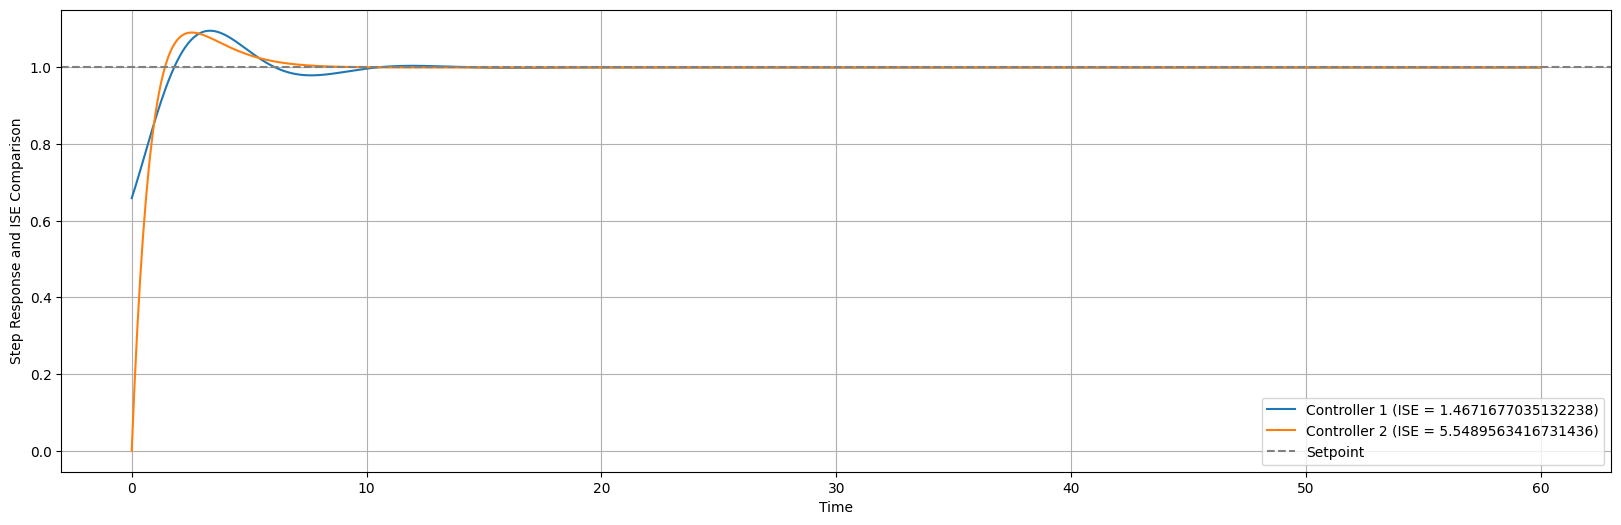

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(t1, y1, label=f'Controller 1 (ISE = {ise1})')
plt.plot(t2, y2, label=f'Controller 2 (ISE = {ise2})')
plt.axhline(setpoint, color='gray', linestyle='--', label='Setpoint')
plt.xlabel('Time')
plt.ylabel('Step Response and ISE Comparison')
plt.legend()
plt.grid()
plt.show()


## Conclusion
Summarize findings related to Direct Synthesis tuning, stability verification via Routh, and performance evaluation through ISE.
- How effective was the Routh criterion in predicting stability?
- How did the ISE metric inform the tuning process and performance evaluation?



In [28]:
# The routh criterion was very effective in understanding how the parameter variations influence stability in order to enable a stable and safe system design

# The ISE metric informs the tuning process by quantifying the error of the system and allowing the controller to tune via feedback. It also evaluates performance through a quantitative error metric.  